In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


In [3]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.moduledict = nn.ModuleDict({
            'fc1' : nn.Linear(784, 128), # All img in MINST are 28x28, 28*28=784
            'fc2' : nn.Linear(128, 128),
            'relu': nn.ReLU(),
            'out' : nn.Linear(128, 10)
        })
    def forward(self, x):
        # x = x.view(-1, 784)
        x = x.view(x.size(0), -1)
        x = self.moduledict.fc1(x)
        x = self.moduledict.relu(x)
        x = self.moduledict.fc2(x)
        x = self.moduledict.relu(x)
        return self.moduledict.out(x)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
train_set = datasets.MNIST('../week 1/dataset/mnist/', train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = datasets.MNIST('../week 1/dataset/mnist/', train=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [7]:
from numpy import shape
from tqdm import tqdm


model = FCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epoch_num = 5

model.train()

for epoch in range(epoch_num):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epoch_num}'):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

Epoch 1/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5: 100%|██████████| 938/938 [00:01<00:00, 624.79it/s]


In [11]:
model.eval()
total_correct = 0
total = 0

num_classes = 10 # MNIST有10个类别 (0-9)
metrics_per_class = {i: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0} for i in range(num_classes)}

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        output = model(images)
        _, predicted_class = torch.max(output.data, 1)

        for class_id in range(num_classes):
            # 将当前 class_id 视为“正类”
            is_positive_class = (labels == class_id)
            is_negative_class = (labels != class_id)

            # 模型预测为当前正类
            predicted_positive = (predicted_class == class_id)
            predicted_negative = (predicted_class != class_id)

            metrics_per_class[class_id]['TP'] += (predicted_positive & is_positive_class).sum().item()
            metrics_per_class[class_id]['FP'] += (predicted_positive & is_negative_class).sum().item()
            metrics_per_class[class_id]['TN'] += (predicted_negative & is_negative_class).sum().item()
            metrics_per_class[class_id]['FN'] += (predicted_negative & is_positive_class).sum().item()

        total += labels.size(0)
        total_correct += (predicted_class == labels).sum().item()
print(f'Accuracy: {100 * total_correct / total:.2f}%')

# # 如果需要计算宏平均 (Macro-average) 或微平均 (Micro-average)
# # 宏平均：先计算每个类别的指标，再取平均
precision = sum(tp / (tp + fp) for tp, fp, _, _ in [(m['TP'], m['FP'], m['TN'], m['FN']) for m in metrics_per_class.values()] if (tp + fp) > 0) / num_classes
recall = sum(tp / (tp + fn) for tp, _, _, fn in [(m['TP'], m['FP'], m['TN'], m['FN']) for m in metrics_per_class.values()] if (tp + fn) > 0) / num_classes
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 微平均：直接使用总的TP, FP, TN, FN来计算
# 注意：对于准确率，微平均精确率、召回率和F1分数都等于总准确率
# total_tp = sum(m['TP'] for m in metrics_per_class.values())
# total_fp = sum(m['FP'] for m in metrics_per_class.values())
# total_fn = sum(m['FN'] for m in metrics_per_class.values())

# precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
# recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
# f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

100%|██████████| 157/157 [00:00<00:00, 754.23it/s]

Accuracy: 97.39%
Precision: 0.9739
Recall: 0.9736
F1-Score: 0.9738


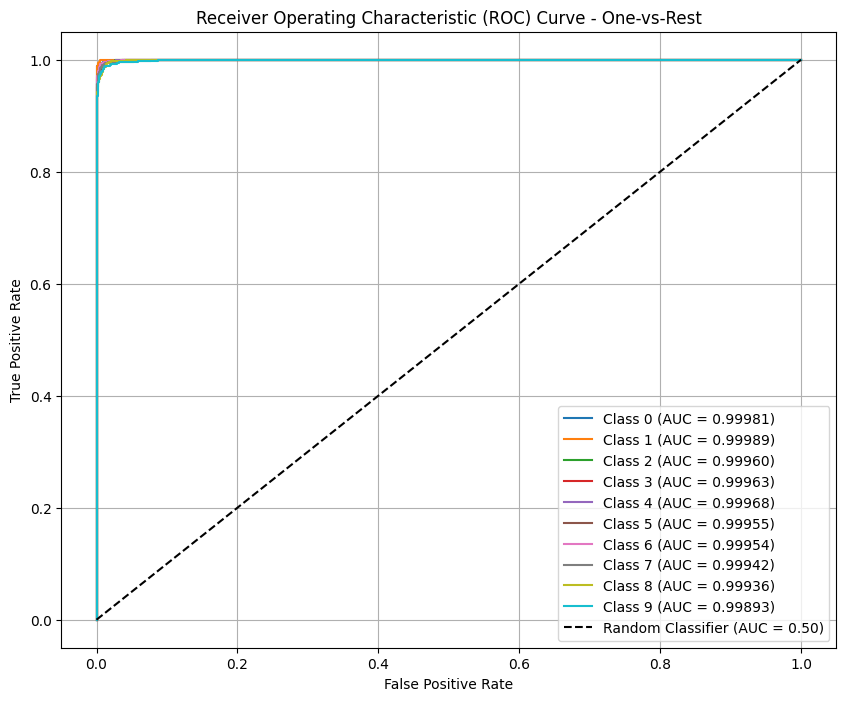

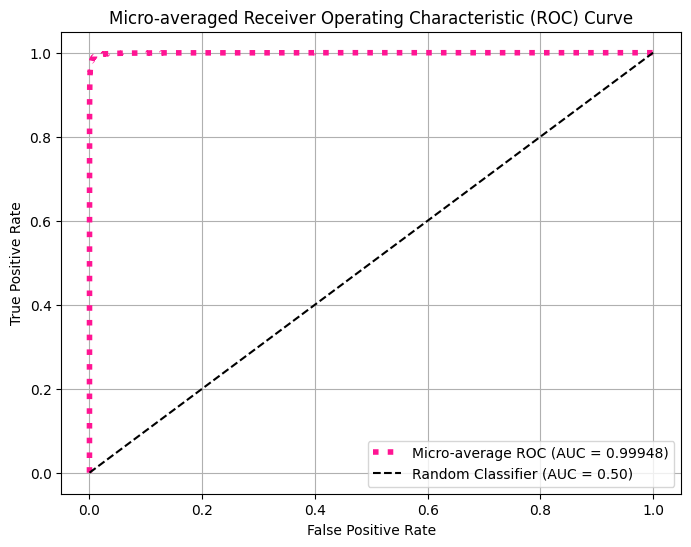

In [16]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F # 导入F.softmax

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Collecting data for ROC"):
        output = model(images)
        # 应用 softmax 获取概率
        probs = F.softmax(output, dim=1)
        
        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# 将所有批次的数据连接起来
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))

# 为每个类别绘制 ROC 曲线
for i in range(num_classes):
    # 将当前类别视为正类 (1)，其他类别为负类 (0)
    binary_labels = (all_labels == i).astype(int)
    class_probs = all_probs[:, i] # 获取当前类别的预测概率

    fpr, tpr, thresholds = roc_curve(binary_labels, class_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.5f})')

# 绘制对角线（随机分类器）
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 如果需要计算并绘制微平均 ROC 曲线
# 将多分类标签转换为二值化矩阵
from sklearn.preprocessing import label_binarize
binarized_labels = label_binarize(all_labels, classes=range(num_classes))

# 计算微平均 ROC 曲线和 AUC
fpr_micro, tpr_micro, _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.5f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()